In [2]:
from multiprocessing.sharedctypes import Value
import sys
import os
from getopt import getopt
from models.seqlab import DNABERT_SL
from utils.seqlab import NUM_LABELS, Index_Dictionary, preprocessing_kmer
from transformers import BertForMaskedLM, BertTokenizer
import json
import torch
from tqdm import tqdm
from utils.metrics import Metrics
import wandb
import numpy as np
import pandas as pd

In [ ]:
# args = parse_args(sys.argv[1:])
# for key in args.keys():
#     print(f"# {key} - {args[key]}")

# use static input first.
args = {
    "device": "cuda:0",
    "model-config": os.path.join("models", "config", "seqlab", "base.lin1.json"),
    "model-checkpoint": os.path.join("run", "sso01-adamw-lr5e-5-base.lin1-2w1boplw", "latest", "checkpoint.pth"),
    "test-config": os.path.join("training", "config", "seqlab", "ss-only.01.lr5e-5.json"),
    "log": os.path.join("prediction", "sso01-adamw-lr5e-5-base.lin1-2w1boplw")
}

device = args.get("device", "cpu") # specify device or use cpu otherwise.

model_config_path = args.get("model-config", False)
model_checkpoint = args.get("model-checkpoint", False)
test_config_path = args.get("test-config")
test_config = json.load(open(test_config_path, "r"))
test_file = test_config.get("test_data", False)

if not model_config_path:
    raise ValueError("model config not specified.")
if not os.path.exists(model_config_path):
    raise ValueError(f"model config not exists at {model_config_path}")
print(f"using model config at {model_config_path}")
    
if not model_checkpoint:
    raise ValueError("model checkpoint not specified.")
if not os.path.exists(model_checkpoint):
    raise ValueError(f"model checkpoint not exists at {model_checkpoint}")
print(f"found model checkpoint at {model_checkpoint}")

if not test_file:
    raise ValueError("test not specified.")
if not os.path.exists(test_file):
    raise ValueError(f"test file not exists at {test_file}")
print(f"found test data at {test_file}")

bert_for_masked_lm = BertForMaskedLM.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
model = DNABERT_SL(
    bert_for_masked_lm.bert, # bert, 
    json.load(open(model_config_path, "r")) # config
)

checkpoint = torch.load(model_checkpoint, map_location=device)
model.load_state_dict(checkpoint.get("model"))
model.eval()
model.to(device)

tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
batch_size = 1
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


In [5]:
logdir = os.path.join("prediction", "log")
os.makedirs(logdir, exist_ok=True)
print(f"found log directory at {logdir}")

# initialize wandb.
run = wandb.init(
    project="prediction",
    entity="anwari32"
)
wandb.define_metric("prediction_step")
wandb.define_metric("prediction/*", step_metric="prediction_step")

found log directory at prediction\log


In [6]:
result = []
prediction_step = 0
device = "cuda:0"
model.to(device)
df_data = {}
token_f1_scores = {}
token_precision = {}
token_recall = {}

for i in range(NUM_LABELS):
    label = Index_Dictionary[i]
    token_f1_scores[label] = []
    token_precision[label] = []
    token_recall[label] = []

for step, batch in tqdm(enumerate(test_dataloader), total=test_size, desc="Testing"):
    input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        predictions, bert_output = model(input_ids, attn_mask)
        for inputs, pred, target_label in zip(input_ids, predictions, target_labels):
            vals, pred_ids = torch.max(pred, 1)
            input_ids_list = inputs.tolist()
            pred_ids_list = pred_ids.tolist()
            target_list = target_label.tolist()
            
            # log to local first.
            input_ids_str = [str(a) for a in input_ids_list]
            input_ids_str = " ".join(input_ids_str)
            pred_ids_str = [str(a) for a in pred_ids_list]
            pred_ids_str = " ".join(pred_ids_str)
            target_ids_str = [str(a) for a in target_list]
            target_ids_str = " ".join(target_ids_str)

            actual_input_ids = input_ids_list[1:] # remove CLS token
            actual_input_ids = [t for t in actual_input_ids if t > 0]
            actual_target_ids = target_list[1:] # remove CLS token
            actual_target_ids = [a for a in actual_target_ids if a >= 0]
            actual_pred_ids = pred_ids_list[1:] # remove CLS prediction
            actual_pred_ids = actual_pred_ids[0:len(actual_target_ids)]

            metrics = Metrics(actual_pred_ids, actual_target_ids)
            metrics.calculate()
            for label_idx in range(NUM_LABELS):
                precision = metrics.precision(label_idx)
                recall = metrics.recall(label_idx)
                f1_score = metrics.f1_score(label_idx)
                label_name = Index_Dictionary[label_idx]
                wandb.log({
                    f"prediction/precision-{label_name}": precision,
                    f"prediction/recall-{label_name}": recall,
                    f"prediction/f1_score-{label_name}": f1_score,
                    "prediction_step": prediction_step
                })
                token_f1_scores[label_name].append(f1_score)
                token_precision[label_name].append(precision)
                token_recall[label_name].append(recall)

            prediction_step += 1

for k in token_f1_scores.keys():
    df_data[f"f1_score-{k}"] = token_f1_scores[k]
    df_data[f"precision-{k}"] = token_precision[k]
    df_data[f"recall-{k}"] = token_recall[k]

df = pd.DataFrame(data=df_data)
df.to_csv(os.path.join(logdir, "prediction_log.csv"),index=False)

run.finish()

Testing: 100%|██████████| 6961/6961 [07:43<00:00, 15.02it/s]


prediction/f1_score-EEE,▂▃▁▁▁▁▁▁▃█▆▄▃▄▇▅▆▇▇▁▁▂▁▅█▆▃▅▆▅▅▇██▆▅▂▂▆▄
prediction/f1_score-EEi,▁▁▁▁▁▁▆▁▆▁▁▁▆▅▆▁███▁▁▁▆▆█▆███▆█▆▅▆▆██▁▁▁
prediction/f1_score-EiE,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
prediction/f1_score-Eii,▁▆▁▁▁▁▆█▆▁▁▁█▁▆▁███▁▁▁▆▆█▅███▆█▆▅▆███▁▁▁
prediction/f1_score-iEE,▁▁▁▁▁▁█▆██▃▆▁▁▁▁▁▂▆▆▁▁▁▅█▄▂▆▅▂▁███▃▅▂▁▁▁
prediction/f1_score-iEi,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
prediction/f1_score-iiE,▁▁▁▁▁▁█▆████▁▁▁█▁█▆▆▁▁▁███▅▆▆▄▁████▆█▁▆▁
prediction/f1_score-iii,▅▆█▇▇█████▇▃▁▆█████▆▃▆▆▇█▇▆▇▇▇▇███▇▇▇▇▇▂
prediction/precision-EEE,▃▂▁▁▁▁▁▁████▇▇▇██▇████▁▄█▄▃▄▅▄▄▆██▅▄▂▂██
prediction/precision-EEi,▁▁▁▁▁▁▅▁▅▁▁▁▅▃▅▁███▁▁▁▅▅█▅███▅█▅▃▅▅██▁▁▁
prediction/precision-EiE,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [9]:
logpath = os.path.join("prediction", "log", "prediction_log.csv")
df = pd.read_csv(logpath)
df["f1_score_total"] = df["f1_score-iii"] + df["f1_score-iiE"] + df["f1_score-iEE"] + df["f1_score-iiE"] + df["f1_score-iEE"] + df["f1_score-EEE"] 
df.head()
df.to_csv(logpath, index=False)


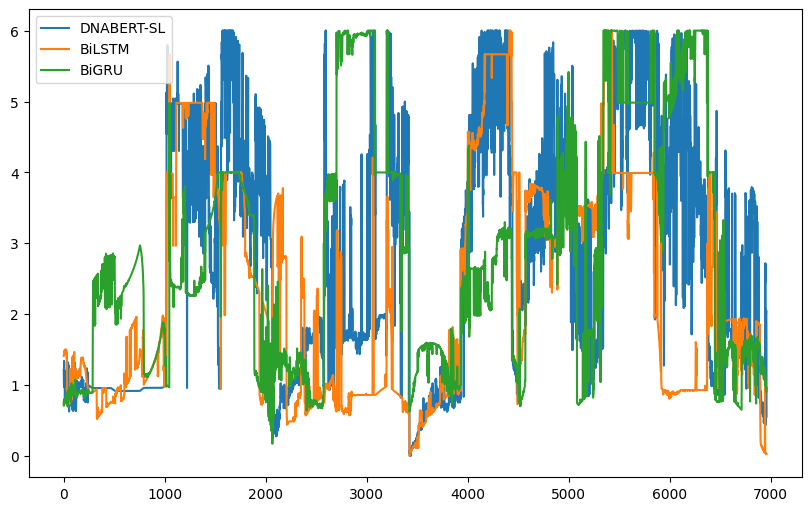

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

logpath = os.path.join("prediction", "log", "prediction_log.csv")
baseline_log_dir = os.path.join("run", "baseline", "kmer", "log", "prediction")
baseline_bilstm_log_path = os.path.join(baseline_log_dir, "log.bilstm.csv")
baseline_bigru_log_path = os.path.join(baseline_log_dir, "log.bigru.csv")

df = pd.read_csv(logpath)
baseline_bilstm_df = pd.read_csv(baseline_bilstm_log_path)
baseline_bigru_df = pd.read_csv(baseline_bigru_log_path)

xs = [i for i in range(df.shape[0])]

figs, axes = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 5))
axes.plot(
    xs,
    df["f1_score_total"].values,
    label="DNABERT-SL"
)

axes.plot(
    xs,
    baseline_bilstm_df["total_f1_score"].values,
    label="BiLSTM"
)


axes.plot(
    xs,
    baseline_bigru_df["total_f1_score"].values,
    label="BiGRU"
)

axes.legend()
plt.show()

    
    

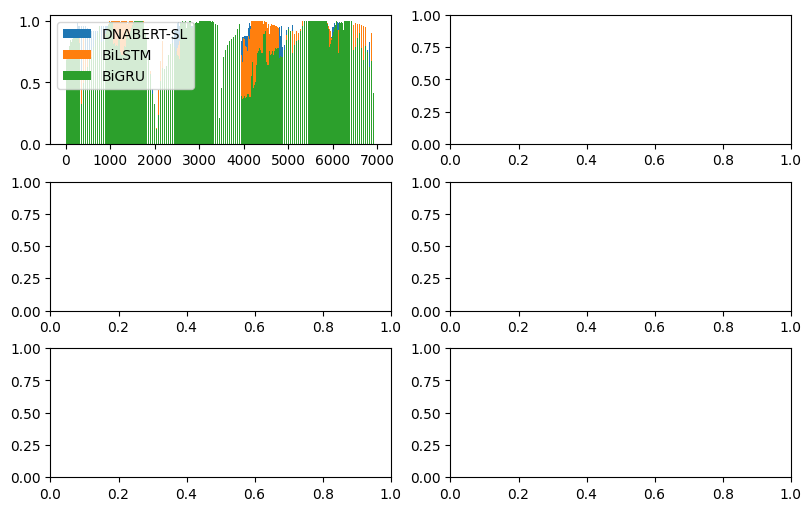

In [25]:
figs, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(8, 5))
axes[0][0].bar(
    xs,
    df["f1_score-iii"].values,
    label="DNABERT-SL"
)

axes[0][0].bar(
    xs,
    baseline_bilstm_df["f1_score-iii"].values,
    label="BiLSTM"
)

axes[0][0].bar(
    xs,
    baseline_bigru_df["f1_score-iii"].values,
    label=f"BiGRU"
)

axes[0][0].legend()

# axes[0][1].plot(
#     xs,
#     df["f1_score-EEE"].values,
#     label=f"DNABERT-SL, mean={round(np.average(df['f1_score-EEE'].values), 2)}"
# )

# axes[0][1].plot(
#     xs,
#     baseline_bilstm_df["f1_score-EEE"].values,
#     label=f"BiLSTM, mean={round(np.average(baseline_bilstm_df['f1_score-EEE'].values), 2)}"
# )

# axes[0][1].plot(
#     xs,
#     baseline_bigru_df["f1_score-EEE"].values,
#     label=f"BiGRU, mean={round(np.average(baseline_bigru_df['f1_score-EEE'].values), 2)}"
# )

# axes[0][1].legend()

# axes[1][0].plot(
#     xs,
#     df["f1_score-iii"].values,
#     label="DNABERT-SL"
# )

# axes[1][0].plot(
#     xs,
#     baseline_bilstm_df["f1_score-iii"].values,
#     label="BiLSTM"
# )

# axes[1][0].plot(
#     xs,
#     baseline_bigru_df["f1_score-iii"].values,
#     label=f"BiGRU, mean={round(np.average(baseline_bigru_df['f1_score-iii'].values), 2)}"
# )

# axes[1][0].legend()

# axes[1][1].plot(
#     xs,
#     df["f1_score-EEE"].values,
#     label=f"DNABERT-SL, mean={round(np.average(df['f1_score-EEE'].values), 2)}"
# )

# axes[1][1].plot(
#     xs,
#     baseline_bilstm_df["f1_score-EEE"].values,
#     label=f"BiLSTM, mean={round(np.average(baseline_bilstm_df['f1_score-EEE'].values), 2)}"
# )

# axes[1][1].plot(
#     xs,
#     baseline_bigru_df["f1_score-EEE"].values,
#     label=f"BiGRU, mean={round(np.average(baseline_bigru_df['f1_score-EEE'].values), 2)}"
# )

# axes[1][1].legend()